In [1]:
import numpy as np
from scipy.linalg import expm, logm

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [4]:
def polynomial_dynamics(t, coefs):
    out = 0
    for i in range(coefs.shape[0]):
        out += t ** i * coefs[i]
    return out

In [81]:
t = 500
r = 6
latent_dynamics = np.zeros((t, r))
latent_dynamics[:, 0] = polynomial_dynamics(np.linspace(-2, 2, t), np.asarray([-1, 1, 0.5, -0.1]))
latent_dynamics[:, 1] = polynomial_dynamics(np.linspace(-2, 2, t), np.asarray([-0.5, -1, 0.2, 0.5]))
latent_dynamics[:, 2] = polynomial_dynamics(np.linspace(-2, 1, t), np.asarray([-0.5, -1, 0.3, -0.2]))
latent_dynamics[:, 3] = polynomial_dynamics(np.linspace(-2, 2, t), np.asarray([-0.5, -0.5, -0.2, 0.1]))
latent_dynamics[:, 4] = polynomial_dynamics(np.linspace(-1, 2, t), np.asarray([1, -1, 0.2, 0.5]))
latent_dynamics[:, 5] = polynomial_dynamics(np.linspace(-2, 1, t), np.asarray([-1, 0.5, 0.2, 0.5]))

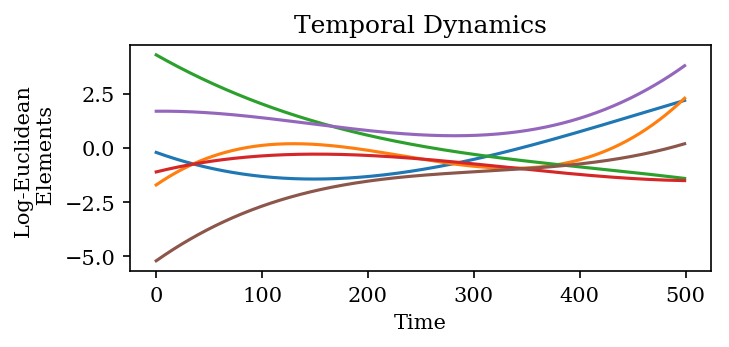

In [82]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for j in range(6):
    plt.plot(latent_dynamics[:, j])
plt.xlabel('Time')
plt.ylabel('Log-Euclidean \n Elements')
plt.title('Temporal Dynamics')
plt.show()

In [7]:
def create_symmetric_matrix(upper):
    mat = np.zeros((3, 3))
    mat[0, :] = upper[:3]
    mat[1, 1:] = upper[3:5]
    mat[2, 2] = upper[5]
    for i in range(1, 3):
        for j in range(i):
            mat[i, j] = mat[j, i]
    return mat

In [9]:
cov_series = np.zeros((t, 3, 3))
for i in range(t):
    cov_series[i, :, :] = expm(create_symmetric_matrix(latent_dynamics[i, :]))

In [10]:
n = 200
time_series = np.zeros((n, t, 3))
for i in range(n):
    for j in range(t):
        time_series[i, j, :] = np.random.multivariate_normal(np.zeros(3), cov_series[j, :, :], 1)

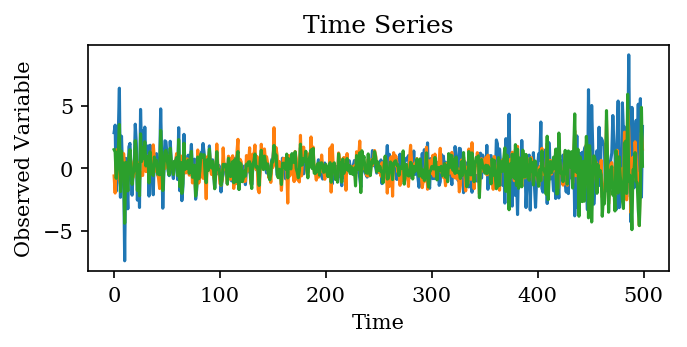

In [11]:
fig = plt.figure(figsize=(5, 2), dpi=150)
for j in range(3):
    plt.plot(time_series[0, :, j])
plt.xlabel('Time')
plt.ylabel('Observed Variable')
plt.title('Time Series')
plt.show()

In [12]:
def sliding_window(time_series, size=50, stride=1):
    """
    Calculate sliding window covariance Log-Euclidean vector time series.

    Args
        time_series: (numpy array) [t, n] t observations in time of n dimensional data
        size: (int) sliding window size
        stride: (int) sliding step size
    """
    t, n = time_series.shape
    # cov_series = np.zeros((t - size, n, n))
    log_series = np.zeros((int((t - size) / stride), int(0.5 * n * (n + 1))))
    for i in range(int((t - size) / stride)):
        window = time_series[(i * stride):(i * stride + size), :]
        cov = np.cov(window, rowvar=False)
        # cov_series[i, :, :] = cov
        log_series[i, :] = logm(cov)[np.triu_indices(n)]
    return log_series

In [13]:
from tqdm import tqdm as tqdm

In [14]:
latent_hat_list = []
for i in tqdm(range(n)):
    latent_hat = sliding_window(time_series[i, :, :], 40)
    latent_hat_list.append(latent_hat)

100%|██████████| 200/200 [04:18<00:00,  1.27s/it]


In [15]:
latent_hat_stack = np.stack(latent_hat_list)

In [16]:
print(latent_hat_stack.shape)

(200, 460, 6)


In [97]:
gustav_klimt = ['#F75323', '#43528D', '#5F7847', '#E3C4C9', '#F7BB48', '#723232']

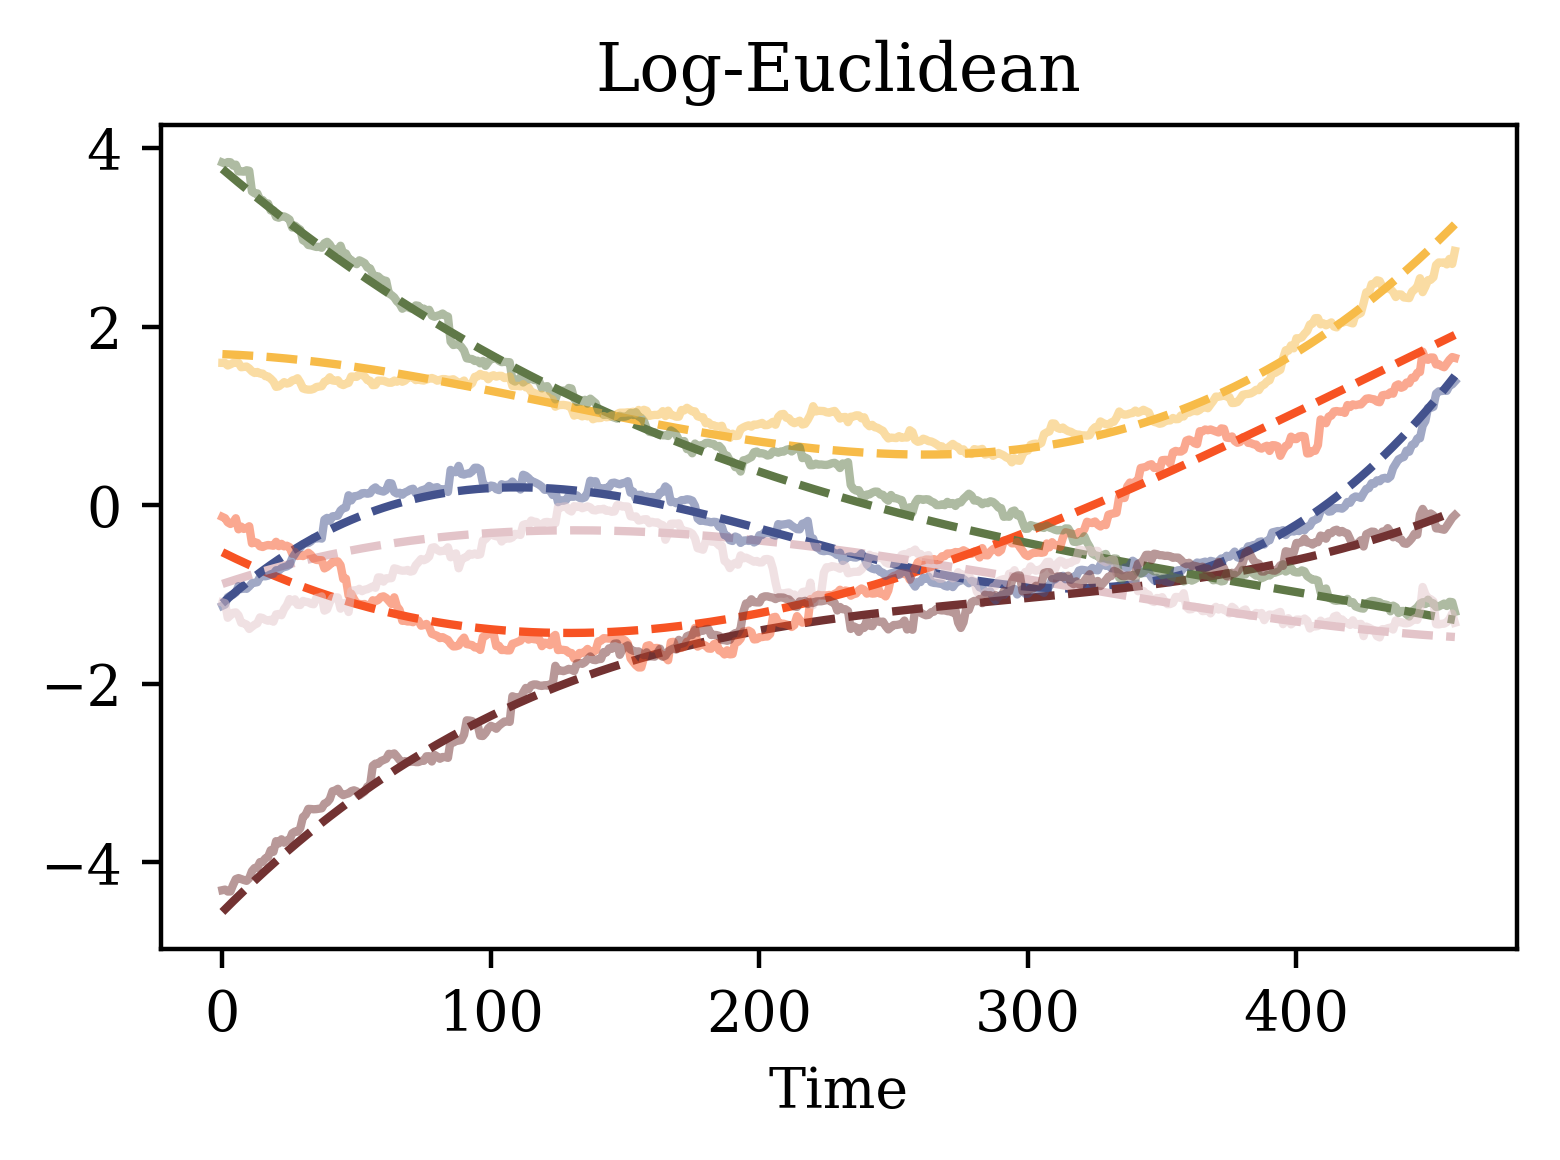

In [98]:
fig = plt.figure(figsize=(4, 3), dpi=400)
for j in range(6):
    plt.plot(latent_dynamics[20:480, j], '--', color=gustav_klimt[j])
for j in range(6):
    plt.plot(latent_hat_stack[0, :, j], color=gustav_klimt[j], alpha=0.5)
plt.xlabel('Time')
plt.title('Log-Euclidean')
plt.tight_layout()
plt.savefig('sliding.png')
plt.show()

In [21]:
latent_error = np.zeros(latent_hat_stack.shape)
for i in range(n):
    latent_error[i, :, :] = latent_hat_stack[i, :, :] - latent_dynamics[20:480, :]

In [22]:
print(latent_error.shape)

(200, 460, 6)


In [23]:
print(np.mean(latent_error ** 2))

0.03661146625619131


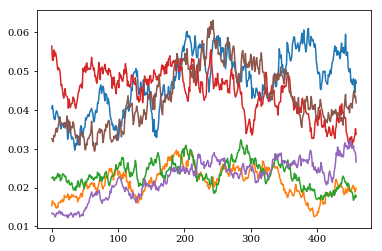

In [41]:
for j in range(6):
    plt.plot(np.std(latent_error[:, :, j], axis=0) ** 2)
plt.show()

In [50]:
from scipy.stats import gaussian_kde

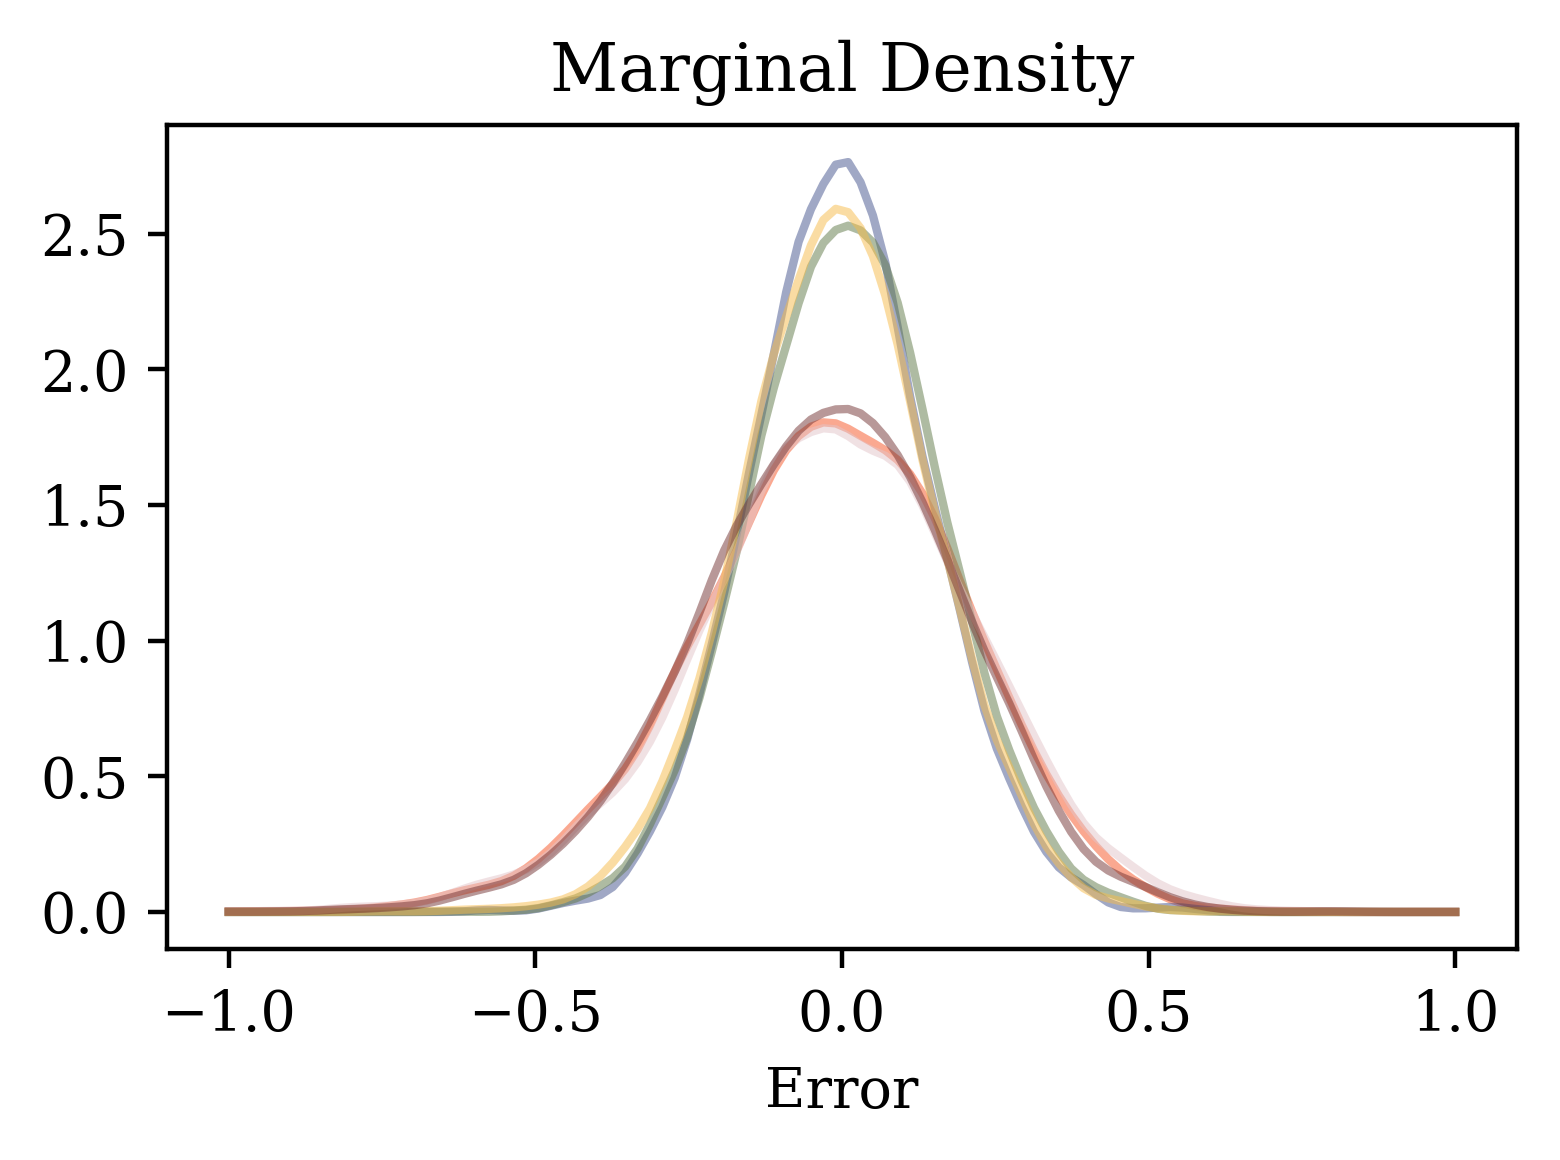

In [99]:
fig = plt.figure(figsize=(4, 3), dpi=400)
for j in range(6):
    density = gaussian_kde(latent_error[:, ::10, j].flatten())
    xs = np.linspace(-1, 1, 100)
    density._compute_covariance()
    plt.plot(xs, density(xs), color=gustav_klimt[j], alpha=0.5)
    #plt.hist(latent_error[:, ::10, j].flatten(), bins=50, alpha=0.2)
plt.xlabel('Error')
plt.title('Marginal Density')
plt.tight_layout()
plt.savefig('normal.png')
plt.show()

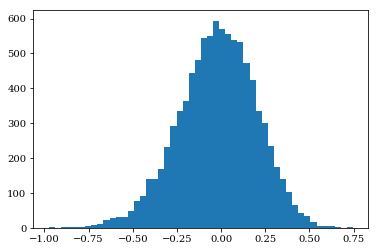

In [31]:
plt.hist(latent_error[:, ::10, 0].flatten(), bins=50)
plt.show()

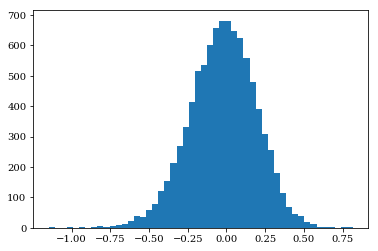

In [33]:
plt.hist(latent_error[:, ::10, 5].flatten(), bins=50)
plt.show()

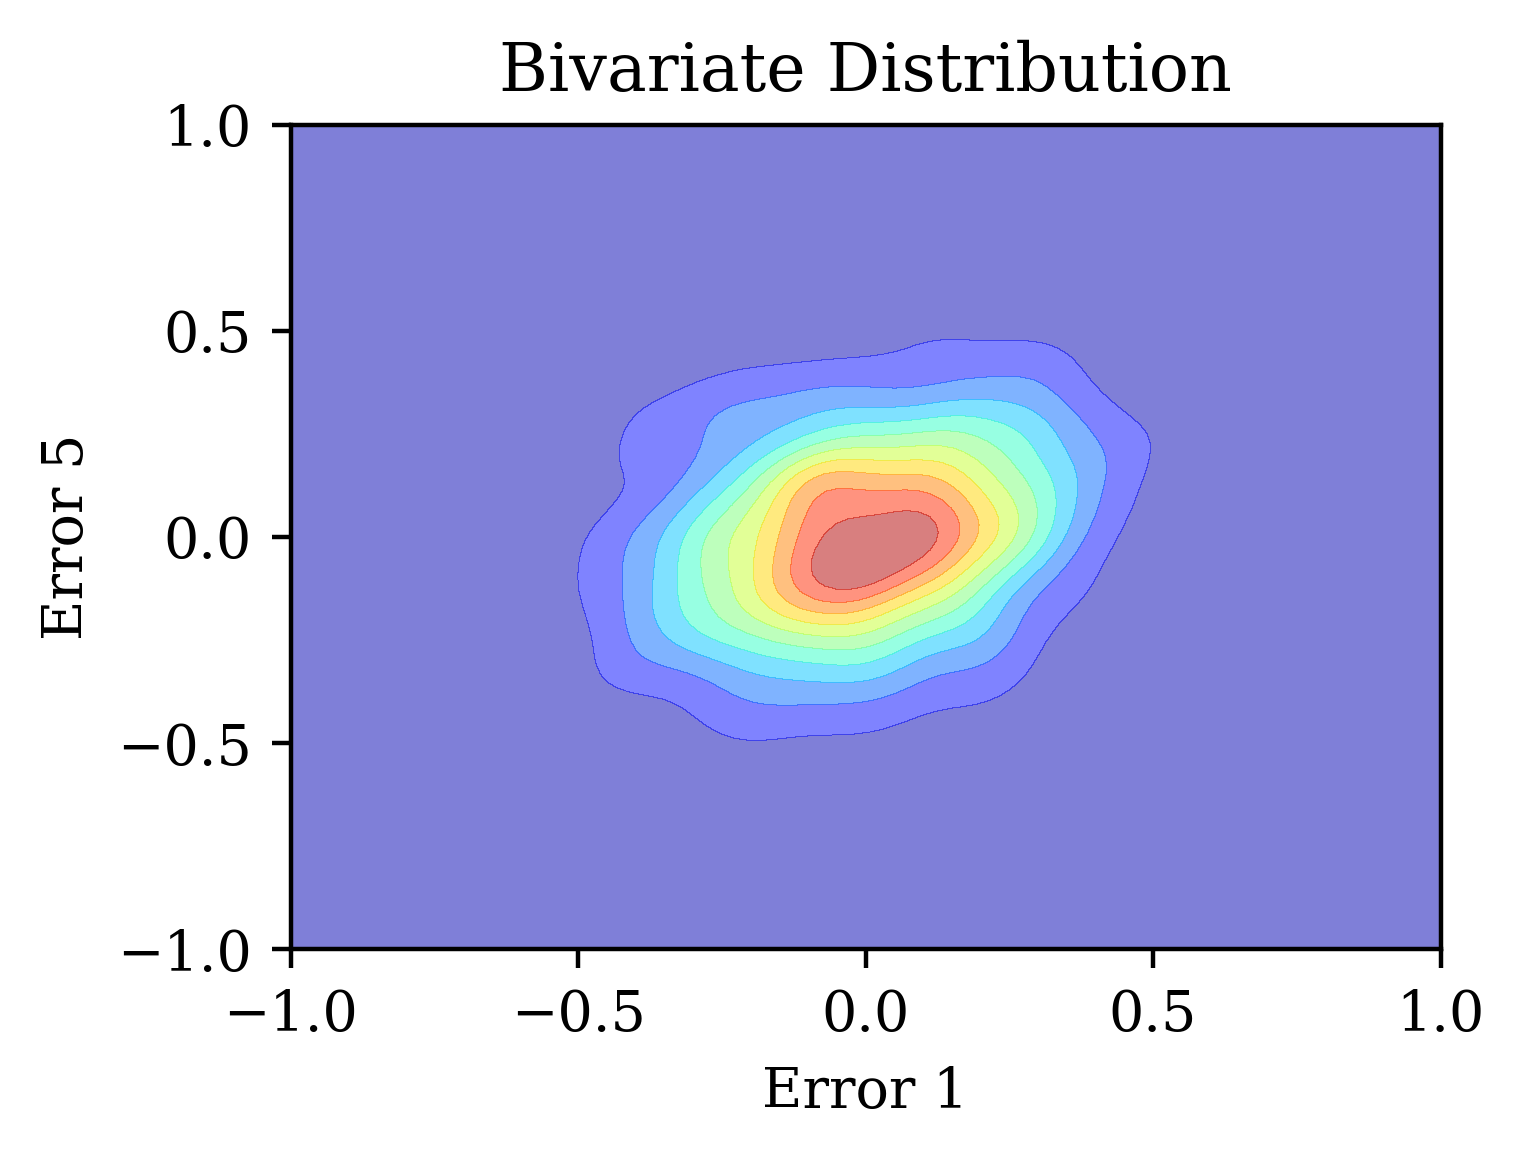

In [91]:
fig = plt.figure(figsize=(4, 3), dpi=400)
x1 = latent_error[:, ::50, 0].flatten()
x2 = latent_error[:, ::50, 5].flatten()
xmin = -1
xmax = 1
ymin = -1
ymax = 1
kernel = gaussian_kde(np.vstack([x1, x2]))
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
plt.contourf(X, Y, Z, 10, cmap='jet', alpha=0.5)
plt.xlabel('Error 1')
plt.ylabel('Error 5')
plt.title('Bivariate Distribution')
plt.tight_layout()
plt.savefig('bivariate.png')
plt.show()